In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
data_path = Path('../data/')
df        = pd.read_csv(data_path / 'interim' / 'fed_emp.csv')

In [4]:
# Removing the lines for which the target in unknown
df                                   = df[~df.EDLVL.isnull()]
# Removing the nan values in columns by either adding a new category
# or dropping the lines
df.loc[df.GSEGRD.isnull(), 'GSEGRD'] = 0
df.loc[df.OCC.isnull(), 'OCC']       = 0
df                                   = df[~df.SUPERVIS.isnull()]
df                                   = df[~df.TOA.isnull()]
df                                   = df[~df.SALARY.isnull()]
df                                   = df[~df.LOS.isnull()]
# df.isnull().sum(axis = 0)

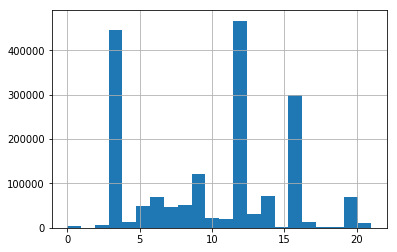

In [5]:
df_data    = df.drop(['EDLVL'], axis = 1)
df_target  = df['EDLVL']
df_target  = df_target - 1 # Values between 0 and 21 instead of 1 and 22
# df_target.hist(bins = 22)

In [6]:
numerical_columns = ['SALARY', 'LOS']
df_num            = df_data[numerical_columns]
df_cat            = df_data.drop(numerical_columns, axis = 1) 

In [7]:
columns_encoders = {
    col : {
        val : i 
        for i, val in enumerate(df[col].unique())
    }
    for col in df_cat.columns
}
column_order = list(columns_encoders.keys())

In [8]:
for col in df_cat.columns:
    df_cat[col] = df_cat[col].apply(lambda x: columns_encoders[col][x])

In [9]:
class CategoricalEmbeddings(nn.Module):
    def __init__(self, col_order, col_encoders, col_to_emb_dim):
        super(CategoricalEmbeddings, self).__init__()
        self.col_order = col_order 
        self.cat_embs  = nn.ModuleDict({
            col: nn.Embedding(len(col_encoders[col]), col_to_emb_dim[col])
            for col in col_order
        })
        
    def forward(self, cat_variables):
        embeddings = [self.cat_embs[col](cat_variables[col]) for col in self.col_order]
        
        return torch.cat(embeddings, dim = 1)

In [10]:
class EdlvlClassifier(nn.Module):
    def __init__(self, col_order, col_encoders, col_to_emb_dim):
        super(EdlvlClassifier, self).__init__()
        self.cat_emb    = CategoricalEmbeddings(col_order, col_encoders, col_to_emb_dim)
        sum_cat_emb_dim = sum(col_to_emb_dim.values())
        self.linear1    = nn.Linear(sum_cat_emb_dim + 2, 128)
        self.linear2    = nn.Linear(128, 22)
        
    def forward(self, cat_variables, num_variables):
#         import pdb
#         pdb.set_trace()
        cat_embeddings = self.cat_emb(cat_variables)
        cat_num_tensor = torch.cat([cat_embeddings, num_variables], dim = 1)
        out_linear1    = F.relu(self.linear1(cat_num_tensor))
        out_linear2    = self.linear2(out_linear1)
        
        return out_linear2

In [11]:
model = EdlvlClassifier(
    column_order,
    columns_encoders,
    {
        col : 2
        for col in columns_encoders
    }
)
model

EdlvlClassifier(
  (cat_emb): CategoricalEmbeddings(
    (cat_embs): ModuleDict(
      (AGELVL): Embedding(12, 2)
      (AGYSUB): Embedding(523, 2)
      (GSEGRD): Embedding(16, 2)
      (LOC): Embedding(219, 2)
      (LOSLVL): Embedding(10, 2)
      (OCC): Embedding(656, 2)
      (PATCO): Embedding(7, 2)
      (PPGRD): Embedding(933, 2)
      (SALLVL): Embedding(25, 2)
      (STEMOCC): Embedding(100, 2)
      (SUPERVIS): Embedding(6, 2)
      (TOA): Embedding(18, 2)
      (WORKSCH): Embedding(10, 2)
      (WORKSTAT): Embedding(2, 2)
    )
  )
  (linear1): Linear(in_features=30, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=22, bias=True)
)

In [12]:
dataset = TensorDataset(
    *[
        torch.tensor(df_cat[col].values)
        for col in column_order
    ], # categorical variables in the correct order
    torch.tensor(df_num.values, dtype = torch.float32), # numerical variables
    torch.tensor(df_target.values, dtype = torch.int32) # target variables
)

In [13]:
loader = DataLoader(dataset, batch_size = 16, shuffle = False)

In [14]:
for *cat_var_list, num_var, y in loader:
    cat_variables = dict(zip(column_order, cat_var_list))
    res = model(cat_variables, num_var)
    
    break